<a href="https://colab.research.google.com/github/diegodh1/learning_ML/blob/main/beer_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
#import the libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #charts
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [59]:
#read the csv file
dataset = pd.read_csv('https://drive.google.com/uc?export=download&id=1H9cJWkCLaW2cVH7qVgFSzwMlgGTwF-Wl', header=None)
dataset = dataset.iloc[1:]
#rename the columns
dataset.columns = [
    'Date',
    'Mean Temperature',
    'Minimum Temperature',
    'Maximum Temperature',
    'Precipitation',
    'Weekend',
    'Beer Consumption'
    
]
del dataset['Date']
dataset.head()

,Mean Temperature,Minimum Temperature,Maximum Temperature,Precipitation,Weekend,Beer Consumption
1,"27,3","23,9","32,5",0,0,25.461
2,"27,02","24,5","33,5",0,0,28.972
3,"24,82","22,4","29,9",0,1,30.814
4,"23,98","21,5","28,6","1,2",1,29.799
5,"23,82",21,"28,3",0,0,28.900


We can see that all the columns are numeric except the weekend column. After understand how is organized the data of our problem, the next step is delete the missing values and replace the "," by "." to avoid problems with numerical calculus.

In [60]:
#drop the empty rows
dataset['Beer Consumption'].replace('', np.nan, inplace=True)
dataset.dropna(subset=['Beer Consumption'], inplace=True)
data = {'Mean Temperature': dataset['Mean Temperature'],
        'Minimum Temperature': dataset['Minimum Temperature'],
        'Maximum Temperature': dataset['Maximum Temperature'],
        'Precipitation': dataset['Precipitation'],
        'Weekend':dataset['Weekend'],
        'Beer Consumption': dataset['Beer Consumption']}
#convert data to dataframe
dataset = pd.DataFrame(data)
#replace , character by .
dataset['Mean Temperature'] = dataset['Mean Temperature'].str.replace(',','.')
dataset['Minimum Temperature'] = dataset['Minimum Temperature'].str.replace(',','.')
dataset['Maximum Temperature'] = dataset['Maximum Temperature'].str.replace(',','.')
dataset['Precipitation'] = dataset['Precipitation'].str.replace(',','.')
dataset['Beer Consumption'] = dataset['Beer Consumption'].str.replace(',','.')
#set the data types of the columns
dataset['Mean Temperature'] = dataset['Mean Temperature'].astype('float')
dataset['Minimum Temperature'] = dataset['Minimum Temperature'].astype('float')
dataset['Maximum Temperature'] = dataset['Maximum Temperature'].astype('float')
dataset['Precipitation'] = dataset['Precipitation'].astype('float')
dataset['Weekend'] = dataset['Weekend'].astype('float')
dataset['Beer Consumption'] = dataset['Beer Consumption'].astype('float')

In [61]:
dataset.describe()

,Mean Temperature,Minimum Temperature,Maximum Temperature,Precipitation,Weekend,Beer Consumption
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.226356,17.461370,26.611507,5.196712,0.284932,25.401367
std,3.180108,2.826185,4.317366,12.417844,0.452001,4.399143
min,12.900000,10.600000,14.500000,0.000000,0.000000,14.343000
25%,19.020000,15.300000,23.800000,0.000000,0.000000,22.008000
50%,21.380000,17.900000,26.900000,0.000000,0.000000,24.867000
75%,23.280000,19.600000,29.400000,3.200000,1.000000,28.631000
max,28.860000,24.500000,36.500000,94.800000,1.000000,37.937000


Let's make some charts to understand better the distribution of the dataset

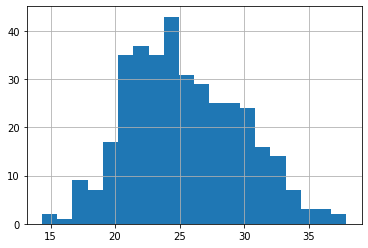

In [62]:
dataset['Beer Consumption'].hist(bins=20)

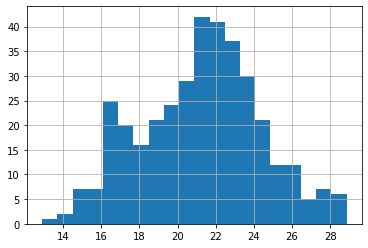

In [63]:
dataset['Mean Temperature'].hist(bins=20)

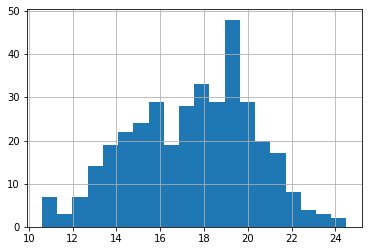

In [64]:
dataset['Minimum Temperature'].hist(bins=20)

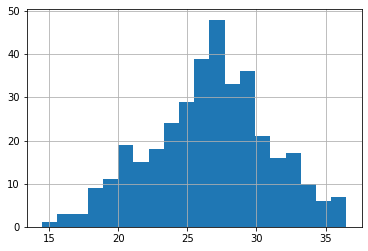

In [65]:
dataset['Maximum Temperature'].hist(bins=20)

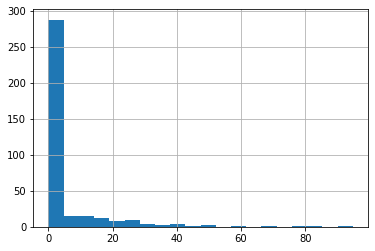

In [66]:
dataset['Precipitation'].hist(bins=20)

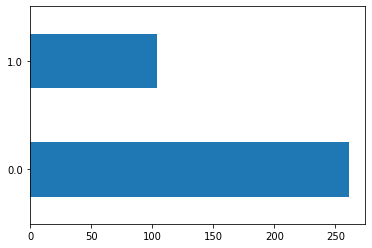

In [67]:
dataset['Weekend'].value_counts().plot(kind='barh')

we can observe that beer consumption is less in the weekend than in the rest of days of the week and almost all the beer consumption occurs when the temperature is between 20 and 30 celsius.

Let's split the data.

In [107]:
data = pd.get_dummies(dataset, [])
#target values
y = data['Beer Consumption'].values
#all the data without the target column
x = data.drop("Beer Consumption", axis = 1)
#split the sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
train_stats = X_train.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Mean Temperature,255.0,21.041725,3.191729,12.9,18.65,21.22,23.15,28.3
Minimum Temperature,255.0,17.269804,2.892345,10.6,15.00,17.50,19.50,24.5
Maximum Temperature,255.0,26.413333,4.316574,14.5,23.40,26.60,29.20,36.5
Precipitation,255.0,4.855686,11.558201,0.0,0.00,0.00,3.10,85.3
Weekend,255.0,0.258824,0.438850,0.0,0.00,0.00,1.00,1.0


create the model

In [211]:
#function to normalize the data
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

#normalize the train dataset
normed_train_data = norm(X_train)
normed_test_data = norm(X_test)

#function to build the model
def build_model():
  model = keras.Sequential([
    layers.Dense(5, activation='linear', input_shape=[len(X_train.keys())]),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 5)                 30        
_________________________________________________________________
dense_115 (Dense)            (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


There are five slopes because each correspond to a feature of our dataset. Let's predict the outputs for the dataset.

In [212]:
#train the model for 1000 epochs
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(
  normed_train_data, y_train,
  epochs=1000, validation_split = 0.2, verbose=0, callbacks=[early_stop])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
303,5.353957,1.957229,5.353957,5.241739,1.973624,5.241739,303
304,5.362062,1.959453,5.362062,5.239208,1.974413,5.239208,304
305,5.355670,1.954039,5.355670,5.230276,1.973871,5.230276,305
306,5.365636,1.953550,5.365636,5.244124,1.975451,5.244124,306
307,5.348027,1.953752,5.348027,5.252606,1.978786,5.252606,307


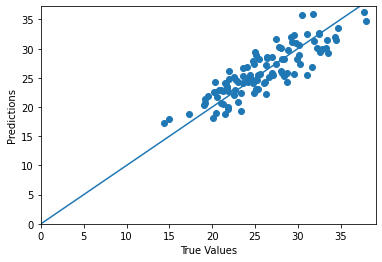

In [213]:
#let's predict the test_set
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-200, 200], [-200, 200])

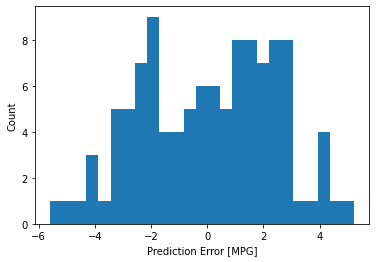

In [214]:
error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")